In [8]:
import math 
import chaospy as cp
from casadi import *
from dataclasses import dataclass
from matplotlib import pyplot as plt
from concurrent.futures import ProcessPoolExecutor, as_completed

In [9]:
@dataclass
class Parameters:
    # Time and discretization
    tf: float = 50          # final time [sec]
    nu: int = 100           # number of control intervals
    dut: float = tf / nu    # time step

    # Aircraft physical constants
    m: float = 4662                 # mass [lb sec^2 / ft]
    g: float = 32.172               # gravity [ft/sec^2]
    delta: float = 0.03491*pi/180   # thrust inclination angle [rad]

    # Thrust model coefficients: T = A0 + A1*V + A2*V^2
    A0: float = 0.4456e5    # [lb]
    A1: float = -0.2398e2   # [lb sec / ft]
    A2: float = 0.1442e-1   # [lb sec^2 / ft^2]

    # Aerodynamic model
    rho: float = 0.2203e-2  # air density [lb sec^2 / ft^4]
    S: float = 0.1560e4     # reference surface area [ft^2]

    # Wind model 3 beta (smoothing) parameters
    beta0: float = 0.3825                   # initial beta value (approximate)
    beta_dot0: float = 0.2                  # initial beta rate
    sigma: float = (1-beta0)/beta_dot0      # time to reach beta = 1 [sec]

    # C_D(alpha) = B0 + B1 * alpha + B2 * alpha**2, D = 0.5 * C_D(α) * ρ * S * V²
    B0: float = 0.1552
    B1: float = 0.12369     # [1/rad]
    B2: float = 2.4203      # [1/rad^2]

    # Lift coefficient: C_L = C0 + C1 * alpha (+ C2 * alpha**2)
    C0: float = 0.7125      # baseline lift coefficient
    C1: float = 6.0877      # AOA lift slope [1/rad]

    # Lift/drag model optional extensions (if needed)
    C2: float = -9.0277     # [rad^-2] — e.g., for moment or drag extension

    # Angle of attack & control constraints
    umax: float = 3*pi/180          # max control input (rate of change of alpha) [rad/sec]
    alphamax: float = 17.2*pi/180   # max angle of attack [rad]
    alpha_star: float = 12*pi/180   # changing pt of AoA

    # Wind model x parameters (piecewise smooth wind)
    a: float = 6e-8         # x transition midpoint [ft]
    b: float = -4e-11       # second transition point [ft]

    # Wind model h parameters (polynomial form)
    c: float = -np.log(25 / 30.6) * 1e-12       # transition smoothing width [ft]
    d: float = -8.02881e-8                      # polynomial coeff [sec^-1 ft^-2]
    e: float = 6.28083e-11                      # polynomial coeff [sec^-1 ft^-3]

    # Cost function / target altitude
    hR: float = 1000        # reference altitude [ft]
    h_star: float = 1000    # used in some wind models

    # Auxiliary
    eps: float = 1e-6  # to avoid division by zero in V

params = Parameters()

In [10]:
def plot_multi_plane_2D(w_opt: list[float], k_values: list[float]):
    N = params.nu
    tf = params.tf
    nk = len(k_values)
    u_opt = w_opt[:N]
    h_min = w_opt[N]
    w = w_opt[N + 1:]

    all_lists = []
    for i in range(nk):
        new_w = w[:N * 5 + 5]
        all_lists.append(new_w)
        w = w[N * 5 + 5:]

    tgrid = [tf / N * k for k in range(N + 1)]

    fig, axs = plt.subplots(1, 2, figsize=(12, 5))

    # --- Altitude vs. Distance ---
    for i in range(nk):
        x1_opt = all_lists[i][0::5]
        x2_opt = all_lists[i][1::5]
        axs[0].plot(x1_opt, x2_opt, label=f'k = {k_values[i]:.3f}')
        print(f"Plane {i}, min(h): {min(x2_opt):.2f}")
    axs[0].grid()
    axs[0].set_xlabel('horizontal distance [ft]')
    axs[0].set_ylabel('altitude [ft]')
    axs[0].legend()

    # --- Control input ---
    axs[1].step(tgrid[:-1], u_opt, where='post')
    axs[1].set_xlabel('t [sec]')
    axs[1].set_ylabel('control u(t) [rad/s]')
    axs[1].set_title('Optimal Control')
    axs[1].grid()

    plt.tight_layout()
    plt.show()


In [11]:
def generate_pce_basis_and_quadrature(pce_order, k_mean=1.0, k_std=0.25):
    dist = cp.Normal(k_mean, k_std)
    nodes, weights = cp.generate_quadrature(pce_order, dist, rule="gaussian")
    nodes = nodes.flatten()
    weights = weights.flatten()
    M = len(nodes)
    basis = cp.expansion.stieltjes(pce_order, dist, retall=False)
    Psi_mat = np.array([[float(basis[j](nodes[i])) for j in range(M)] for i in range(M)])
    # Psi_dm = ca.DM(Psi_mat)
    weights_dm = DM(weights.reshape(1, -1))
    return nodes, weights, Psi_mat, weights_dm

In [29]:
def solve_ocp_multi_plane_min_h_pceaware(k_values: list[float], Psi: np.ndarray,
                                         lambda1: float = 10.0, lambda2: float = 5.0):
    '''
    PCE-aware OCP solver with stochastic constraints
    Input:
        k_values: PCE nodes (length = M)
        Psi: Basis matrix of size [M, M], where Psi[i,j] = phi_j(k_i)
        lambda1: penalty on (hR - E[h_T])^2
        lambda2: penalty on Var[h_T]
    Return:
        w_opt: Optimal decision variables
        J_opt: optimal objective value
    '''
    nk = len(k_values)  # Number of k:s (M)
    Psi_dm = DM(Psi)
    Psi_inv = inv(Psi_dm)  # Precompute inverse of basis matrix

    # State, Time and Control
    x1 = SX.sym('x1')  # x
    x2 = SX.sym('x2')  # h
    x3 = SX.sym('x3')  # V
    x4 = SX.sym('x4')  # gamma
    x5 = SX.sym('x5')  # alpha
    t = SX.sym('t')    # time
    u = SX.sym('u')    # control
    x = vertcat(x1, x2, x3, x4, x5)

    # Wind model expressions (same for all nodes)
    A1 = -50 + params.a * x1 ** 3 + params.b * x1 ** 4
    A2 = 0.025 * (x1 - 2300)
    A3 = 50 - params.a * (4600 - x1) ** 3 - params.b * (4600 - x1) ** 4
    A4 = 50
    A = if_else(x1 <= 500, A1,
                if_else(x1 <= 4100, A2,
                        if_else(x1 <= 4600, A3, A4)))

    B1 = params.d * x1 ** 3 + params.e * x1 ** 4
    B2 = -51 * exp(-params.c * (x1 - 2300) ** 4)
    B3 = params.d * (4600 - x1) ** 3 + params.e * (4600 - x1) ** 4
    B4 = 0
    B = if_else(x1 <= 500, B1,
                if_else(x1 <= 4100, B2,
                        if_else(x1 <= 4600, B3, B4)))

    # NLP setup
    w = []      # Decision variables
    w0 = []     # Initial guess
    lbw = []    # Lower bounds
    ubw = []    # Upper bounds
    g = []      # Constraints
    lbg = []    # Lower bound constraints
    ubg = []    # Upper bound constraints

    # Control variables
    U = MX.sym('U', params.nu)
    w.append(U)
    lbw += [-params.umax] * params.nu
    ubw += [params.umax] * params.nu
    w0 += [0] * params.nu

    # Minimal height variable (to maximize)
    min_h = MX.sym('min_h')
    w.append(min_h)
    lbw.append(0)
    ubw.append(inf)
    w0.append(300)

    # Storage for terminal heights and all angles of attack
    h_final_list = [None] * nk  # Terminal heights for each node
    alpha_all = []               # Angles of attack at all time steps
    
    # Preallocate storage for alpha values
    for i in range(nk):
        alpha_all.append([None] * (params.nu + 1))

    # Add each plane (node) to NLP
    for i in range(nk):
        k_value = k_values[i]

        # Node-specific wind expressions
        wind_x_expr = k_value * A
        wind_x = Function('wind_x', [x1], [wind_x_expr])
        wind_h_expr = k_value * x2 * B / params.h_star
        wind_h = Function('wind_h', [x1, x2], [wind_h_expr])

        # Wind gradients
        dWx_dx = Function("dWx_dx", [x1], [gradient(wind_x_expr, x1)])
        dWh_dx = Function("dWh_dx", [x1, x2], [gradient(wind_h_expr, x1)])
        dWh_dh = Function("dWh_dh", [x1, x2], [gradient(wind_h_expr, x2)])

        # Lift coefficient model
        C_L = if_else(x5 > params.alpha_star, 
                      params.C0 + params.C1 * x5,
                      params.C0 + params.C1 * x5 + params.C2 * (x5 - params.alpha_star) ** 2)

        # Thrust decay model
        beta = if_else(t < params.sigma,
                       params.beta0 + params.beta_dot0 * t, 
                       1.0)

        # Aerodynamic forces
        T = beta * (params.A0 + params.A1 * x3 + params.A2 * x3 ** 2)
        D = 0.5 * (params.B0 + params.B1 * x5 + params.B2 * x5 ** 2) * params.rho * params.S * x3 ** 2
        L = 0.5 * params.rho * params.S * C_L * x3 ** 2

        # Dynamics equations
        x1dot = x3 * cos(x4) + wind_x(x1)
        x2dot = x3 * sin(x4) + wind_h(x1, x2)
        
        wxdot = dWx_dx(x1) * x1dot
        whdot = dWh_dx(x1, x2) * x1dot + dWh_dh(x1, x2) * x2dot
        x3_safe = fmax(x3, params.eps)

        x3dot = (T / params.m * cos(x5 + params.delta) - D / params.m - params.g * sin(x4) - (wxdot * cos(x4))+ whdot * sin(x4))
        x4dot = (T / (params.m * x3) * sin(x5 + params.delta) + 
                 L / (params.m * x3) - 
                 params.g / x3_safe * cos(x4) + 
                 (1 / x3_safe) * (wxdot * sin(x4) - whdot * cos(x4)))
        x5dot = u

        # Dynamics function
        f = Function('f', [x, u, t], [vertcat(x1dot, x2dot, x3dot, x4dot, x5dot)])

        # Vertical acceleration for constraint
        x2dotdot_expr = x3dot * sin(x4) + x3 * x4dot * cos(x4) + whdot
        x2dotdot = Function('x2dotdot', [x, u, t], [x2dotdot_expr])

        # RK4 integration
        def rk4_step(xk, uk, tk, dt):
            k1 = f(xk, uk, tk)
            k2 = f(xk + dt / 2 * k1, uk, tk + dt / 2)
            k3 = f(xk + dt / 2 * k2, uk, tk + dt / 2)
            k4 = f(xk + dt * k3, uk, tk + dt)
            return xk + dt / 6 * (k1 + 2 * k2 + 2 * k3 + k4)

        # Initial condition
        x_initial = [0, 600, 239.7, -2.249 * pi / 180, 7.353 * pi / 180]
        Xk = MX.sym(f'X0_{i}', 5)
        w.append(Xk)
        lbw += x_initial
        ubw += x_initial
        w0 += x_initial
        
        # Store initial angle of attack
        alpha_all[i][0] = Xk[4]

        Tk = 0  # Current time

        # Time-stepping
        for k in range(params.nu):
            Uk = U[k]
            
            # Integrate one step
            Xk_end = rk4_step(Xk, Uk, Tk, params.dut)
            h_ddot_val = x2dotdot(Xk, Uk, Tk)
            Tk += params.dut

            # Next state variables
            Xk = MX.sym(f'X{k+1}_{i}', 5)
            w.append(Xk)
            
            # Bounds for next state
            lbw += [-inf, 0, -inf, -inf, -params.alphamax]
            ubw += [inf, inf, inf, inf, params.alphamax]
            w0 += [k * 10000 / params.nu, 600, 239.7, 0, 0.1]
            
            # Dynamics continuity constraint
            g.append(Xk_end - Xk)
            lbg += [0] * 5
            ubg += [0] * 5

            # Minimum height constraint
            g.append(Xk[1] - min_h)
            lbg.append(0)
            ubg.append(inf)
            
            # Vertical acceleration constraint
            g.append(h_ddot_val)
            lbg.append(-2 * params.g)
            ubg.append(10 * params.g)
            
            # Store angle of attack for this time step
            alpha_all[i][k+1] = Xk[4]

        # Terminal flight path angle constraint (γ ≥ 0)
        g.append(Xk[3])
        lbg.append(0)
        ubg.append(inf)
        
        # Store terminal height for this node
        h_final_list[i] = Xk[1]

    # ===== PCE CONSTRAINTS =====
    # 1. 3σ constraints on angle of attack at all time steps
    for t in range(params.nu + 1):  # For each time step
        # Collect alpha values at this time step for all nodes
        alpha_t = vertcat(*[alpha_all[i][t] for i in range(nk)])
        
        # Compute PCE coefficients: c = Ψ⁻¹ * α
        coeffs = mtimes(Psi_inv, alpha_t)
        
        # Mean is first coefficient
        mu = coeffs[0]
        
        # Standard deviation (σ) is L2-norm of higher-order coefficients
        if nk > 1:
            sigma = norm_2(coeffs[1:])
        else:
            sigma = 0
        
        # 3σ constraints: μ - 3σ ≥ -α_max and μ + 3σ ≤ α_max
        g.append(mu - 3 * sigma)
        lbg.append(-params.alphamax)
        ubg.append(inf)
        
        g.append(mu + 3 * sigma)
        lbg.append(-inf)
        ubg.append(params.alphamax)

    # ===== OBJECTIVE FUNCTION =====
    # Collect terminal heights for all nodes
    h_final_vec = vertcat(*h_final_list)
    
    # Compute PCE coefficients for terminal height
    h_coeffs = mtimes(Psi_inv, h_final_vec)
    
    # Terminal height statistics
    h_mean = h_coeffs[0]  # Expected value
    if nk > 1:
        h_std = norm_2(h_coeffs[1:])  # Standard deviation
    else:
        h_std = 0
    
    # Objective components:
    # 1. Maximize minimum height (-min_h)
    # 2. Penalize deviation from reference height (λ1 term)
    # 3. Penalize height variance (λ2 term)
    # J = (-min_h + 
    #      lambda1 * ((params.hR - h_mean) / params.hR) ** 6 + 
    #      lambda2 * (h_std / params.hR) ** 0)
    
    J = ((params.hR - h_mean + h_std * 12) / 1000) ** 6

    # ===== SOLVE NLP =====
    opts = {'ipopt': {'print_level': 3, 'max_iter': 1000}}
    nlp = {'x': vertcat(*w), 'f': J, 'g': vertcat(*g)}
    solver = nlpsol('solver', 'ipopt', nlp, opts)
    arg = {'x0': w0, 'lbx': lbw, 'ubx': ubw, 'lbg': lbg, 'ubg': ubg}

    sol = solver(**arg)
    w_opt = sol['x'].full().flatten()
    J_opt = float(sol['f'])

    return w_opt, J_opt

In [30]:
nodes, weights, Psi_mat, weights_dm = generate_pce_basis_and_quadrature(pce_order=5)
res_pce = solve_ocp_multi_plane_min_h_pceaware(nodes.tolist(), Psi_mat, lambda1=1.0, lambda2=1.0)

Total number of variables............................:     3101
                     variables with only lower bounds:      601
                variables with lower and upper bounds:      700
                     variables with only upper bounds:        0
Total number of equality constraints.................:     3000
Total number of inequality constraints...............:     1408
        inequality constraints with only lower bounds:      707
   inequality constraints with lower and upper bounds:      600
        inequality constraints with only upper bounds:      101


Number of Iterations....: 1000

                                   (scaled)                 (unscaled)
Objective...............:   9.6527923577319943e+03    9.6527923577319943e+03
Dual infeasibility......:   4.9725878505371713e+02    4.9725878505371713e+02
Constraint violation....:   1.0059669476693573e-04    1.2098273384708591e-04
Variable bound violation:   0.0000000000000000e+00    0.0000000000000000e+00
Complementa

Plane 0, min(h): 205.19
Plane 1, min(h): 162.65
Plane 2, min(h): 123.48
Plane 3, min(h): 83.89
Plane 4, min(h): 43.61
Plane 5, min(h): 0.18


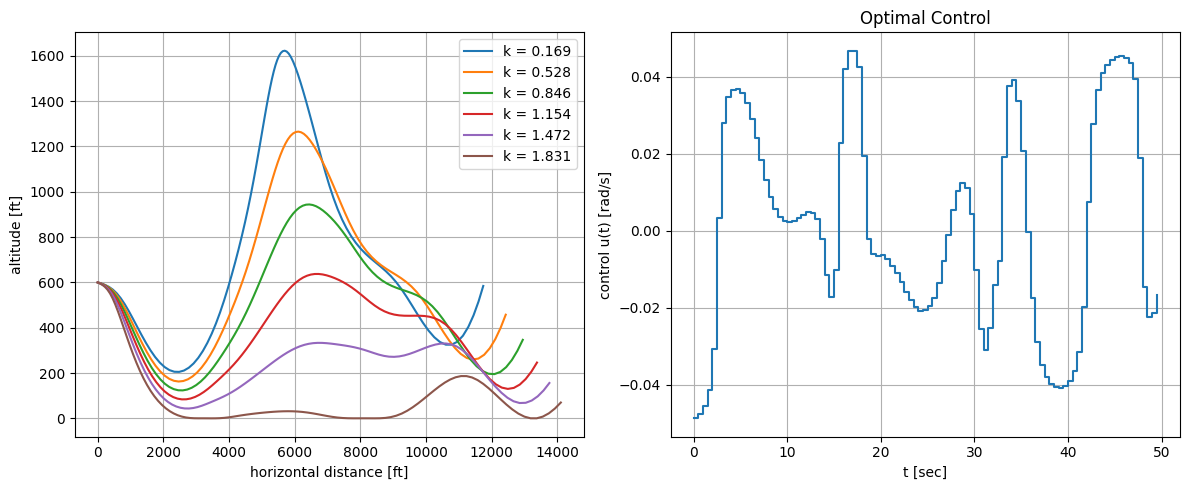

In [31]:
plot_multi_plane_2D(res_pce[0], nodes)